**Black-Scholes vs. Market Pricing for AAPL Call Options**

In this notebook, we analyze European call options on Apple Inc. (AAPL) and compare their market prices with the theoretical prices computed using the Black-Scholes formula. We begin by downloading historical stock data to estimate the annualized volatility of AAPL returns. Then, we retrieve the option chain for the nearest expiration date and apply the Black-Scholes model to compute fair call option prices using this historical volatility. Finally, we visualize and compare the model-generated prices with actual market prices and mid prices (average of bid and ask), highlighting how real-world trading conditions and implied volatility influence option pricing relative to theoretical expectations.

## 📈 Black-Scholes Formula for a European Call Option

The **Black-Scholes formula** gives the theoretical price of a **European call option**, assuming lognormal stock price behavior and constant volatility and interest rates.

The formula is:

$$
C = S \cdot N(d_1) - K e^{-rT} \cdot N(d_2)
$$

Where:

- \( C \): Price of the European **call option**  
- \( S \): Current stock price (spot price)  
- \( K \): Strike price (agreed price to buy the stock at expiry)  
- \( T \): Time to maturity (in years)  
- \( r \): Annual risk-free interest rate (continuously compounded)  
- \( \sigma \): Volatility of the stock (annualized standard deviation of returns)  
- \( N(\cdot) \): Cumulative distribution function (CDF) of the **standard normal distribution**  
- \( d_1 \) and \( d_2 \) are defined as:

$$
d_1 = \frac{\ln(S/K) + (r + \frac{1}{2} \sigma^2)T}{\sigma \sqrt{T}}, \quad
d_2 = d_1 - \sigma \sqrt{T}
$$

---


📌 This formula is only valid for **European options** (which can only be exercised at expiration) and assumes **no dividends** are paid on the stock.


**Note**: The code in this notebook pulls up-to-date market data each time it’s executed. When you run it on your own, it will retrieve the most recent AAPL stock price, the latest option chain, and the closest expiration date available at that moment. Because of this, your results might not exactly match mine — and that’s expected. The analysis adjusts to the current market environment, making it both practical and timely.


In [1]:
# !pip install yfinance==0.2.54

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime
from datetime import datetime
import os


In [2]:
#  Define Black-Scholes Formula in Python

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call

In [3]:
# To apply the Black-Scholes formula, we first need an estimate of the stock's volatility.
# In this section, we load historical price data for Apple (AAPL) from Yahoo Finance and compute 
# the daily log returns. Using these returns, we calculate the historical volatility, which is then 
# annualized assuming 252 trading days in a year. This volatility serves as an input for the theoretical 
# pricing of call options using the Black-Scholes model.

filename = 'aapl_historical_data.csv'

if os.path.exists(filename):
    # Load data from CSV
    data = pd.read_csv(filename, index_col=0, parse_dates=True)
else:
    # Download and process data
    ticker = yf.Ticker("AAPL")
    data = yf.download("AAPL", start="2024-01-01", end="2024-05-01")
    

# Display data
data.head()

# Calculate historical volatility (annualized)

daily_vol = data['log_return'].std()
hist_vol = daily_vol * np.sqrt(252)

print(f"Historical Volatility (Annualized): {hist_vol:.4f}")


Historical Volatility (Annualized): 0.2087


In [4]:
# We now download the options data using yfinance. The ticker.options attribute returns a list of available 
# expiration dates for the stock’s options. For each expiration date, we can access the full option chain
# (calls and puts) using ticker.option_chain(expiration_date). This gives us two separate pandas DataFrames: 
# one for call options (calls) and one for put options (puts). Each DataFrame contains detailed information
# for all option contracts expiring on that date, including the strike price, last traded price, bid/ask quotes,
# implied volatility, and more. This structure allows us to analyze and compare different strikes and maturities.

# Set ticker symbol and filenames
ticker_symbol = 'AAPL'

expiration_filename = 'aapl_expirations.txt'

ticker = yf.Ticker(ticker_symbol)

# Get and store expiration dates if not already saved
if os.path.exists(expiration_filename):
    with open(expiration_filename, 'r') as f:
        expirations = f.read().splitlines()
else:
    expirations = ticker.options
    with open(expiration_filename, 'w') as f:
        f.write('\n'.join(expirations))

print("Available expiration dates:", expirations)

# Pick nearest expiration
nearest_exp = expirations[0]

print(f"\nNearest expiration date: {nearest_exp}")

# When we look at call options for a stock like AAPL, we notice several listed for the same expiration date 
# but with different strike prices. This variety exists so that traders can choose contracts that align
# with their expectations about how much the stock might move.

# A call option gives the holder the right - though not the obligation - to buy the underlying stock at a
# set strike price before it expires. Options with lower strike prices are more likely to be "in the money,"
# meaning they have a higher chance of being profitable, so they tend to cost more. In contrast, those with 
# higher strike prices are cheaper since there's a lower chance they’ll end up being worth anything by expiration.


Available expiration dates: ['2025-05-30', '2025-06-06', '2025-06-13', '2025-06-20', '2025-06-27', '2025-07-03', '2025-07-18', '2025-08-15', '2025-09-19', '2025-10-17', '2025-11-21', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-09-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17']

Nearest expiration date: 2025-05-30


In [5]:
options_filename = 'aapl_call_options.csv'

# Load or download call options for nearest expiration
if os.path.exists(options_filename):
    calls = pd.read_csv(options_filename, index_col=0)
else:
    opt_chain = ticker.option_chain(nearest_exp)
    calls = opt_chain.calls
    calls.to_csv(options_filename, index=True)

# Display call options data
calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL250530C00110000,2025-05-28 13:30:07+00:00,110.0,90.40,89.40,90.95,-0.040001,-0.044229,3.0,6,3.501954,True,REGULAR,USD
1,AAPL250530C00120000,2025-05-27 13:35:26+00:00,120.0,77.83,79.45,80.95,0.000000,0.000000,4.0,2,3.050784,True,REGULAR,USD
2,AAPL250530C00125000,2025-05-27 13:39:37+00:00,125.0,73.09,74.35,75.95,0.000000,0.000000,2.0,9,2.839847,True,REGULAR,USD
3,AAPL250530C00130000,2025-05-27 13:39:37+00:00,130.0,68.16,69.45,70.95,0.000000,0.000000,2.0,2,2.634769,True,REGULAR,USD
4,AAPL250530C00135000,2025-05-27 13:35:26+00:00,135.0,62.81,64.35,65.95,0.000000,0.000000,3.0,3,2.435551,True,REGULAR,USD


In [6]:
# The following code fetches the current stock price, calculates the time to option expiry in years,
# sets the risk-free rate, and adds these key parameters to the options DataFrame for analysis.

price_filename = 'aapl_latest_price.csv'

# Check if saved price data exists
if os.path.exists(price_filename):
    price_df = pd.read_csv(price_filename, index_col=0, parse_dates=True)
    S = price_df['Close'].iloc[-1]  # Use last saved Close price
    price_date = price_df.index[-1].date()
else:
    ticker = yf.Ticker("AAPL")
    price_df = ticker.history(period='1d')
    price_df.to_csv(price_filename)
    S = price_df['Close'].iloc[-1]
    price_date = price_df.index[-1].date()

print(f"Price date: {price_date}")

# Calculate time to maturity in years
expiry_date = datetime.strptime(nearest_exp, '%Y-%m-%d')
today = datetime.today()
T = round((expiry_date - today).total_seconds() / (365.0 * 24 * 60 * 60), 6)


print(f"Expiry date: {expiry_date}")
print(f"Today: {today}")
print(f"T: {T}")


Price date: 2025-05-28
Expiry date: 2025-05-30 00:00:00
Today: 2025-05-29 17:33:56.309282
T: 0.000735


In [7]:
# Risk-free rate
r = 0.05

# Add stock price, time to maturity, and risk-free rate to calls DataFrame
calls = calls.copy()
calls['S'] = S
calls['T'] = T
calls['r'] = r

calls[['strike', 'lastPrice', 'impliedVolatility', 'S', 'T', 'r']].head()


,strike,lastPrice,impliedVolatility,S,T,r
0,110.0,90.40,3.501954,200.419998,0.000735,0.05
1,120.0,77.83,3.050784,200.419998,0.000735,0.05
2,125.0,73.09,2.839847,200.419998,0.000735,0.05
3,130.0,68.16,2.634769,200.419998,0.000735,0.05
4,135.0,62.81,2.435551,200.419998,0.000735,0.05


In [8]:
# In the next part, we calculate the theoretical price of each call option using the Black-Scholes formula,
# with the historical volatility we estimated earlier. We then compare these theoretical values to the
# actual market prices (last traded prices) for the same options. This helps us understand how closely
# the Black-Scholes model aligns with real market behavior and where it might overprice or underprice the options.

# Calculate theoretical BS call prices using historical volatility
calls['BS_Price'] = calls.apply(
    lambda row: black_scholes_call(
        S=row['S'],
        K=row['strike'],
        T=row['T'],
        r=row['r'],
        sigma=hist_vol
    ), axis=1)

calls["mid_price"] = (calls["bid"] + calls["ask"]) / 2

# Show comparison: Market last price vs Black-Scholes price
calls[['strike', 'lastPrice', 'mid_price', 'BS_Price']].head()




# Note: While this project uses historical volatility - calculated from past stock price movements -
# to price options via the Black-Scholes model, it is important to note that the market's implied volatility
# (also included in the options data) reflects the volatility level that, when input into the model, 
# matches the actual price of the option. In other words, implied volatility is a form of "reverse engineering"
# the market price, revealing the market's expectations of future volatility, whereas historical volatility is 
# based purely on past data. Comparing both provides valuable insights into how market sentiment deviates from 
# historical trends. 

,strike,lastPrice,mid_price,BS_Price
0,110.0,90.40,90.175,90.424041
1,120.0,77.83,80.200,80.424408
2,125.0,73.09,75.150,75.424592
3,130.0,68.16,70.200,70.424776
4,135.0,62.81,65.150,65.424959


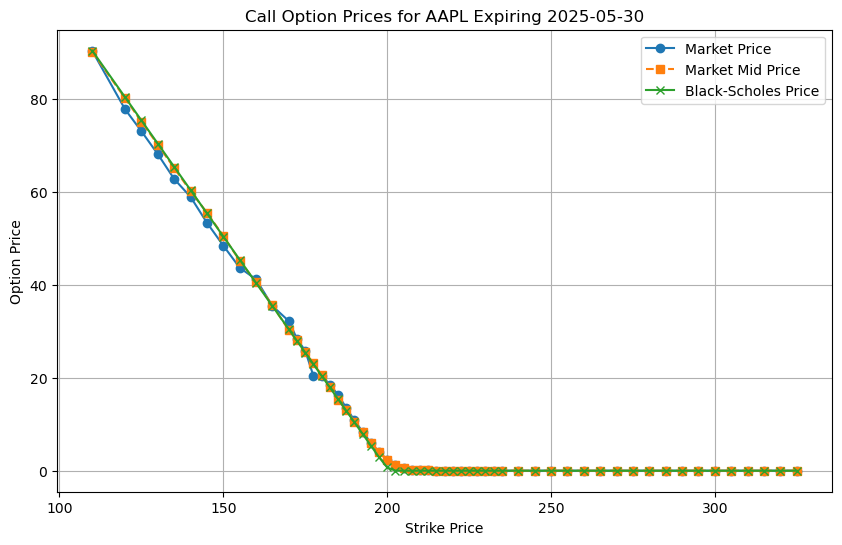

In [9]:
# Finally, we visualize and compare the different option prices across strike prices.

plt.figure(figsize=(10,6))
plt.plot(calls['strike'], calls['lastPrice'], label='Market Price', marker='o')
plt.plot(calls["strike"], calls["mid_price"], label="Market Mid Price", linestyle="--", marker='s')
plt.plot(calls['strike'], calls['BS_Price'], label='Black-Scholes Price', marker='x')

plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title(f'Call Option Prices for AAPL Expiring {nearest_exp}')
plt.legend()
plt.grid(True)
plt.show()